# External Forcing Plots in Sigma-P Coordinates

In [1]:
import warnings

warnings.filterwarnings("ignore")

In [2]:
from functools import partial
from operator import itemgetter

import iris
import matplotlib.pyplot as plt
import numpy as np
from iris.experimental import stratify
from matplotlib.offsetbox import AnchoredText

In [3]:
import aeolus
from aeolus.calc import after_n_day_mean, sigma_p, spatial_mean, time_mean, zonal_mean
from aeolus.const import init_const
from aeolus.coord import get_cube_rel_days, isel
from aeolus.model import um
from aeolus.plot import (
    add_custom_legend,
    cube_minmeanmax_str,
    subplot_label_generator,
    tex2cf_units,
)
from aeolus.subset import DimConstr, extract_last_n_days, unique_cubes

In [4]:
import pouch
from pouch.plot import (
    KW_AUX_TTL,
    KW_MAIN_TTL,
    KW_SBPLT_LABEL,
    KW_SYM0,
    KW_ZERO_LINE,
    figsave,
    linspace_pm1,
    use_style,
)

KW_SYM0 = {**KW_SYM0, "cmap": "seismic"}

import paths
import quickplot as qplt
from interp_to_sigma_p import SIGMA_LEVELS
from lfric_model import lfric
from shared import MODELS
from shared import TF_CASES as SIM_CASES
from shared import load_proc_data, cube_minmeanmax_nonweighted_str

In [5]:
plt.style.use("custom.mplstyle")
# plt.style.use("seaborn-v0_8-darkgrid")
pouch.RUNTIME.figsave_stamp = False

In [6]:
import scooby

scooby.doo(
    core=sorted(
        ["aeolus", "iris", "matplotlib", "numpy", "dask", "esmf_regrid", "stratify"]
    ),
    optional=[],
)

--------------------------------------------------------------------------------
  Date: Mon Mar 20 17:18:10 2023 UTC

                OS : Linux
            CPU(s) : 192
           Machine : x86_64
      Architecture : 64bit
               RAM : 503.5 GiB
       Environment : Jupyter
       File system : ext4

  Python 3.10.8 | packaged by conda-forge | (main, Nov 22 2022, 08:26:04) [GCC
  10.4.0]

            aeolus : 0.4.16+5.gfe423ce.dirty
              dask : 2022.11.0
       esmf_regrid : 0.5.0
              iris : 3.4.0
        matplotlib : 3.6.2
             numpy : 1.23.5
          stratify : 0.2.post0
--------------------------------------------------------------------------------

In [7]:
# height_theta, height_rho = the_run.extract("height_above_reference_ellipsoid")
# height_theta = np.linspace(0, 32000, 33)
# height_rho = np.linspace(1000, 32000, 32) - 500

In [8]:
runs_sigma_p = {}
for model_key, model_prop in MODELS.items():
    runs_sigma_p[model_key] = {}

    for sim_label, sim_prop in SIM_CASES.items():
        fname = sorted(
            (model_prop["results_path"] / sim_label).glob(f"{sim_label}*_sigma_p.nc")
        )[0]
        runs_sigma_p[model_key][sim_label] = load_proc_data(fname)

## Zonal mean cross-sections

In [9]:
DIAGS = {
    "temp": {
        "recipe": lambda cl, model=lfric: zonal_mean(
            after_n_day_mean(cl.extract_cube(model.temp), 200, model=model), model=model
        ),
        "title": "Air Temperature",
        "tex_units": "$K$",
        "plt_method": ["contourf", "contour"],
        "kw_plt": [
            {"cmap": "plasma", "levels": np.arange(190, 311, 10), "extend": "both"},
            {
                "colors": "k",
                "linewidths": 0.5,
                "levels": np.arange(200, 400, 10),
            },
        ],
        "add_colorbar": [False, False],
        "add_clabel": [False, True],
    },
    "u": {
        "recipe": lambda cl, model=lfric: zonal_mean(
            after_n_day_mean(cl.extract_cube(model.u), 200, model=model), model=model
        ),
        "title": "Eastward Wind",
        "tex_units": "$m$ $s^{-1}$",
        "plt_method": ["contourf", "contour"],
        "kw_plt": [
            {"cmap": "RdBu_r", "levels": np.arange(-32, 33, 4), "extend": "both"},
            {
                "colors": "k",
                "linewidths": 0.5,
                "levels": np.arange(-200, 200, 4),
            },
        ],
        "add_colorbar": [False, False],
        "add_clabel": [False, True],
    },
}

### Plot all cases

In [10]:
add_minmeanmax = True
fmt = "auto"

Saved to ../figures/exf__um__hs__zm__temp_u.png


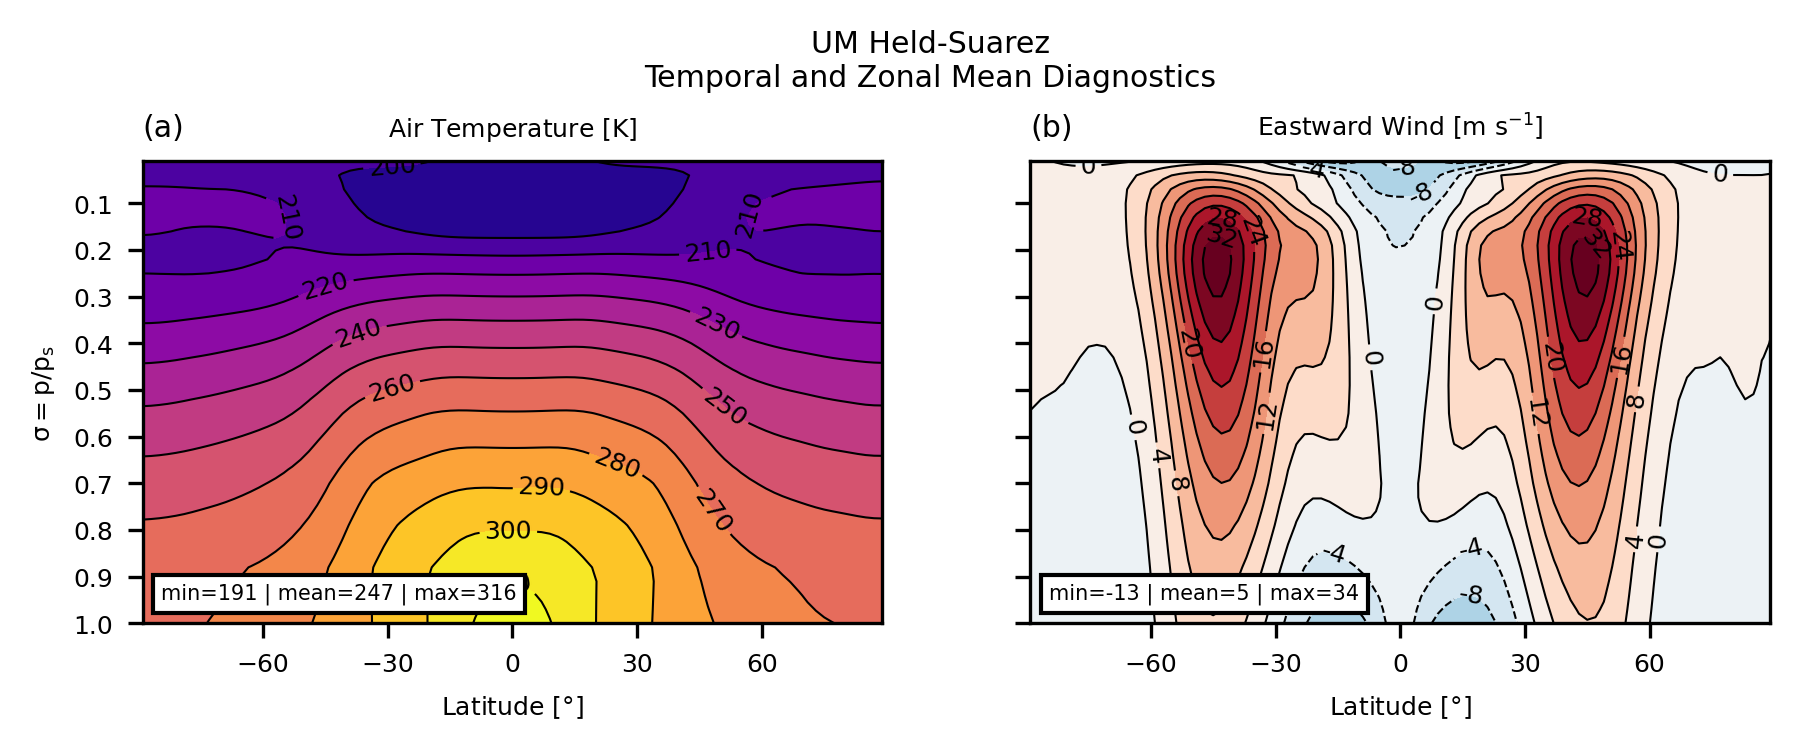

In [11]:
for model_key, model_prop in MODELS.items():
    model = model_prop["model"]

    for sim_label in ["hs", "el"]:
        sim_prop = SIM_CASES[sim_label]

        fig = plt.figure(figsize=(7, 2))
        fig.suptitle(
            f"{model_prop['title']} {sim_prop['title']}\nTemporal and Zonal Mean Diagnostics",
            y=1.1,
        )
        axd = fig.subplot_mosaic(
            qplt.make_list_2d(DIAGS.keys(), ["lfric"]),
            gridspec_kw={"wspace": 0.2},
            sharex=True,
            sharey=True,
        )
        iletters = subplot_label_generator()
        for ax in axd.values():
            ax.set_title(f"({next(iletters)})", loc="left")
            ax.set_xticks(np.arange(-90, 91, 30))
            ax.set_yticks(np.arange(1.0, 0.0, -0.1))
            ax.set_ylim(itemgetter(0, -1)(SIGMA_LEVELS))
            ax.set_xlim(-89, 89)

            if ax.get_subplotspec().is_last_row():
                ax.set_xlabel("Latitude [$\degree$]")
            if ax.get_subplotspec().is_first_col():
                ax.set_ylabel("$\sigma=p/p_s$")

        for diag_key, diag_prop in DIAGS.items():
            ax = axd[f"{diag_key}-lfric"]
            tex_units = diag_prop["tex_units"]
            ttl = diag_prop["title"]
            if tex_units != "1":
                ttl += f" [{tex_units}]"
            ax.set_title(ttl, size="medium", loc="center")
            # ax.set_title(model_prop["title"], size="medium", loc="right")

            cube = diag_prop["recipe"](runs_sigma_p[model_key][sim_label], model=model)
            cube.convert_units(tex2cf_units(diag_prop["tex_units"]))
            x = cube.coord(lfric.y).points
            y = cube.coord(lfric.s).points
            z = cube.data

            plt_items = itemgetter("plt_method", "kw_plt", "add_colorbar", "add_clabel")
            for plt_method, kw_plt, add_colorbar, add_clabel in zip(
                *plt_items(diag_prop)
            ):
                pic = getattr(ax, plt_method)(x, y, z, **kw_plt)
                if add_colorbar:
                    fig.colorbar(pic, ax=ax)
                if add_clabel:
                    ax.clabel(pic, fmt="%.0f", use_clabeltext=True)
            if add_minmeanmax:
                ax.add_artist(
                    AnchoredText(
                        cube_minmeanmax_nonweighted_str(cube, fmt=fmt),
                        loc="lower left",
                        frameon=True,
                        prop={"size": "small"},
                    )
                )
        figsave(
            fig,
            paths.figures
            / f"exf__{model_key}__{sim_label}__zm__{'_'.join(DIAGS.keys())}",
        )
        break
    break
        

## Maps for the TLE case

In [31]:
sim_label = "tle"
sim_prop = SIM_CASES[sim_label]

In [32]:
from aeolus.coord import nearest_coord_value


def reduce_func(cube, s_lev):
    cube_slice = cube.extract(
        iris.Constraint(**{lfric.s: nearest_coord_value(cube, lfric.s, s_lev)})
    )
    return after_n_day_mean(cube_slice, 200)

In [33]:
llev = 0.97
ulev = 0.225
DIAGS = {
    "temp-llev": {
        "recipe": lambda cl, model: reduce_func(cl.extract_cube(model.temp), 0.97),
        "title": "Air Temperature",
        "tex_units": "$K$",
        "plt_method": ["contourf", "contour"],
        "kw_plt": [
            {"cmap": "plasma", "levels": np.arange(270, 321, 10), "extend": "both"},
            {
                "colors": "k",
                "linewidths": 0.5,
                "levels": np.arange(200, 400, 10),
            },
        ],
        "add_colorbar": [False, False],
        "add_clabel": [False, True],
    },
    "temp-ulev": {
        "recipe": lambda cl, model: reduce_func(cl.extract_cube(model.temp), ulev),
        "title": "Air Temperature",
        "tex_units": "$K$",
        "plt_method": ["contourf", "contour"],
        "kw_plt": [
            {"cmap": "plasma", "levels": np.arange(215, 223, 1), "extend": "both"},  #
            {
                "colors": "k",
                "linewidths": 0.5,
                "levels": np.arange(200, 400, 1),
            },
        ],
        "add_colorbar": [False, False],
        "add_clabel": [False, True],
    },
    "u-llev": {
        "recipe": lambda cl, model: reduce_func(cl.extract_cube(model.u), llev),
        "title": "Eastward Wind",
        "tex_units": "$m$ $s^{-1}$",
        "plt_method": ["contourf", "contour"],
        "kw_plt": [
            {"cmap": "RdBu_r", "levels": np.arange(-36, 37, 4), "extend": "both"},
            {
                "colors": "k",
                "linewidths": 0.5,
                "levels": np.arange(-200, 200, 4),
            },
        ],
        "add_colorbar": [False, False],
        "add_clabel": [False, True],
    },
    "u-ulev": {
        "recipe": lambda cl, model: reduce_func(cl.extract_cube(model.u), ulev),
        "title": "Eastward Wind",
        "tex_units": "$m$ $s^{-1}$",
        "plt_method": ["contourf", "contour"],
        "kw_plt": [
            {"cmap": "RdBu_r", "levels": np.arange(-36, 37, 4), "extend": "both"},
            {
                "colors": "k",
                "linewidths": 0.5,
                "levels": np.arange(-200, 200, 4),
            },
        ],
        "add_colorbar": [False, False],
        "add_clabel": [False, True],
    },
    "v-llev": {
        "recipe": lambda cl, model: reduce_func(cl.extract_cube(model.v), llev),
        "title": "Northward Wind",
        "tex_units": "$m$ $s^{-1}$",
        "plt_method": ["contourf", "contour"],
        "kw_plt": [
            {"cmap": "RdBu_r", "levels": np.arange(-36, 37, 4), "extend": "both"},
            {
                "colors": "k",
                "linewidths": 0.5,
                "levels": np.arange(-200, 200, 4),
            },
        ],
        "add_colorbar": [False, False],
        "add_clabel": [False, True],
    },
    "v-ulev": {
        "recipe": lambda cl, model: reduce_func(cl.extract_cube(model.v), ulev),
        "title": "Northward Wind",
        "tex_units": "$m$ $s^{-1}$",
        "plt_method": ["contourf", "contour"],
        "kw_plt": [
            {"cmap": "RdBu_r", "levels": np.arange(-36, 37, 4), "extend": "both"},
            {
                "colors": "k",
                "linewidths": 0.5,
                "levels": np.arange(-200, 200, 4),
            },
        ],
        "add_colorbar": [False, False],
        "add_clabel": [False, True],
    },
}

In [36]:
add_minmeanmax = True
fmt = "pretty"

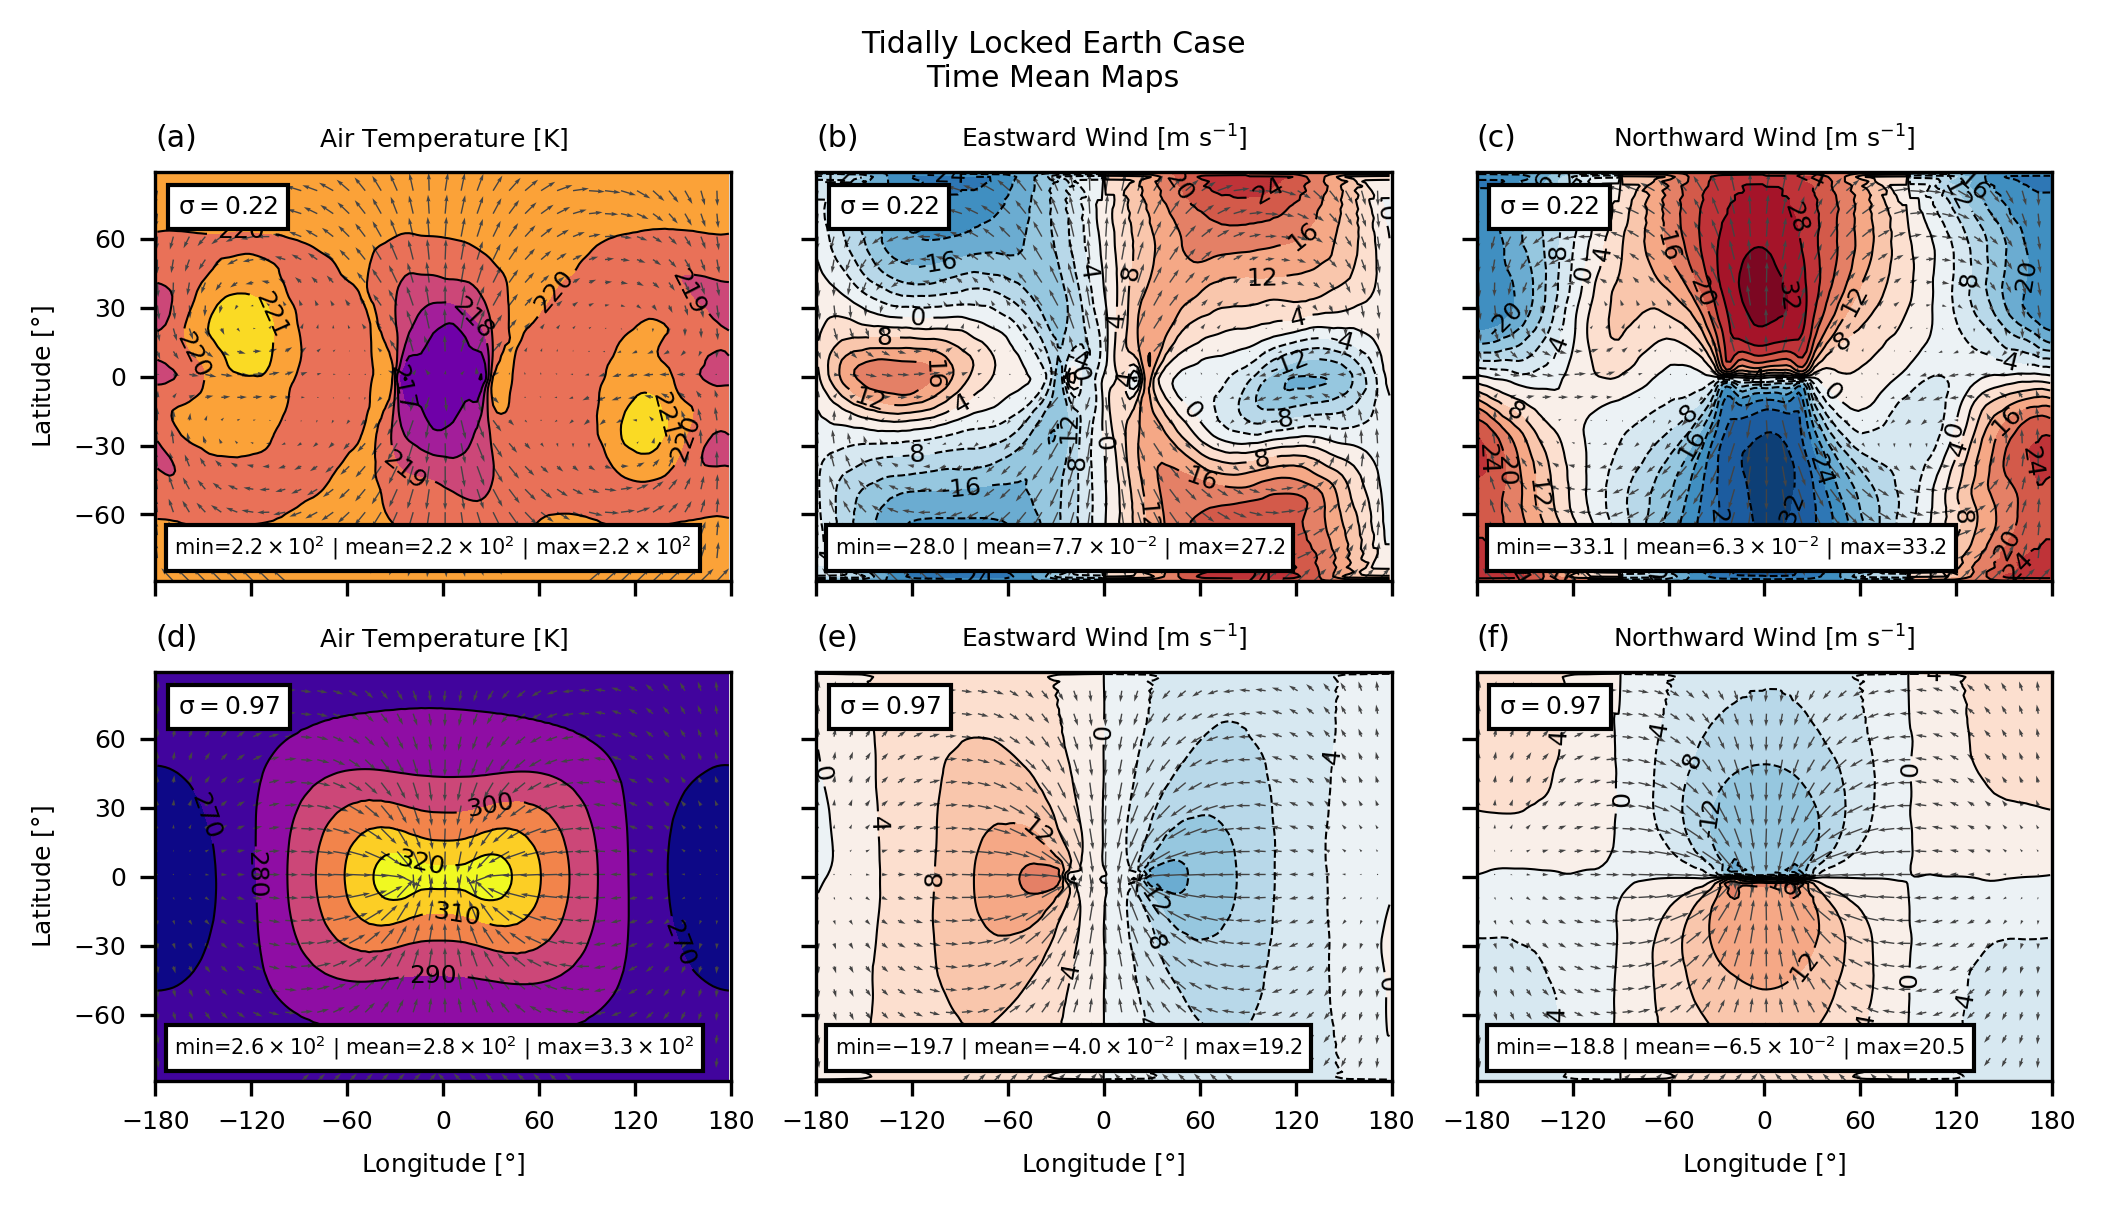

In [37]:
fig = plt.figure(figsize=(7, 4), tight_layout=True)
fig.suptitle(f"{sim_prop['title']} Case\nTime Mean Maps", y=0.98)
axd = fig.subplot_mosaic(
    qplt.make_list_2d(["temp", "u", "v"], ["ulev", "llev"]),
    # gridspec_kw={"wspace": 0.2},
    sharex=True,
    sharey=True,
)
iletters = subplot_label_generator()
for ax_key, ax in axd.items():
    ax.set_title(f"({next(iletters)})", loc="left")
    ax.set_yticks(np.arange(-90, 91, 30))
    ax.set_ylim(-89, 89)
    ax.set_xticks(np.arange(-180, 181, 60))
    ax.set_xlim(-180, 180)
    if ax.get_subplotspec().is_last_row():
        ax.set_xlabel("Longitude [$\degree$]")
    if ax.get_subplotspec().is_first_col():
        ax.set_ylabel("Latitude [$\degree$]")

    diag_key = ax_key
    diag_prop = DIAGS[diag_key]

    tex_units = diag_prop["tex_units"]
    ttl = diag_prop["title"]
    if tex_units != "1":
        ttl += f" [{tex_units}]"
    ax.set_title(ttl, size="medium", loc="center")

    cube = diag_prop["recipe"](runs_sigma_p[sim_label], model=lfric)
    cube.convert_units(tex2cf_units(diag_prop["tex_units"]))
    # cube = roll_cube_0_360(cube, model=lfric)

    x = cube.coord(lfric.x).points
    y = cube.coord(lfric.y).points
    z = cube.data

    plt_items = itemgetter("plt_method", "kw_plt", "add_colorbar", "add_clabel")
    for plt_method, kw_plt, add_colorbar, add_clabel in zip(*plt_items(diag_prop)):
        pic = getattr(ax, plt_method)(x, y, z, **kw_plt)
        if add_colorbar:
            fig.colorbar(pic, ax=ax)
        if add_clabel:
            ax.clabel(pic, fmt="%.0f", use_clabeltext=True)
    ax.add_artist(
        AnchoredText(
            f"$\sigma={{{cube.coord(lfric.s).points[0]:.2f}}}$",
            loc="upper left",
            frameon=True,
        )
    )
    if add_minmeanmax:
        ax.add_artist(
            AnchoredText(
                cube_minmeanmax_nonweighted_str(cube, fmt=fmt),
                loc="lower left",
                frameon=True,
                prop={"size": "small"},
            )
        )

    # Add quivers
    s_lev = cube.coord(lfric.s).points[0]
    u = reduce_func(runs_sigma_p[sim_label].extract_cube(lfric.u), s_lev)
    v = reduce_func(runs_sigma_p[sim_label].extract_cube(lfric.v), s_lev)
    xsl, ysl = slice(None, None, 4), slice(None, None, 5)
    ax.quiver(x[xsl], y[ysl], u.data[ysl, xsl], v.data[ysl, xsl], color="#444444")

# figsave(
#     fig,
#     paths.figures / f"exf__lfric__{sim_label}__{'_'.join(DIAGS.keys())}",
# )

## Meridional section

In [23]:
interp_to_equator = lambda cube, model=lfric: cube.interpolate(
    [(model.y, 0)], iris.analysis.Linear()
)

In [24]:
DIAGS = {
    "temp": {
        "recipe": lambda cl, model=lfric: interp_to_equator(
            after_n_day_mean(
                cl.extract_cube(model.temp),
                200,
                model=model,
            )
        ),
        "title": "Air Temperature",
        "tex_units": "$K$",
        "plt_method": ["contourf", "contour"],
        "kw_plt": [
            {"cmap": "plasma", "levels": np.arange(190, 311, 10), "extend": "both"},
            {
                "colors": "k",
                "linewidths": 0.5,
                "levels": np.arange(200, 400, 10),
            },
        ],
        "add_colorbar": [False, False],
        "add_clabel": [False, True],
    },
    "u": {
        "recipe": lambda cl, model=lfric: interp_to_equator(
            after_n_day_mean(cl.extract_cube(model.u), 200, model=model), model=model
        ),
        "title": "Eastward Wind",
        "tex_units": "$m$ $s^{-1}$",
        "plt_method": ["contourf", "contour"],
        "kw_plt": [
            {"cmap": "RdBu_r", "levels": np.arange(-32, 33, 4), "extend": "both"},
            {
                "colors": "k",
                "linewidths": 0.5,
                "levels": np.arange(-200, 200, 4),
            },
        ],
        "add_colorbar": [False, False],
        "add_clabel": [False, True],
    },
    "w": {
        "recipe": lambda cl, model=lfric: interp_to_equator(
            after_n_day_mean(cl.extract_cube(model.w), 200, model=model), model=model
        ),
        "title": "Vertical Wind",
        "tex_units": "$cm$ $s^{-1}$",
        "plt_method": ["contourf", "contour"],
        "kw_plt": [
            {"cmap": "RdBu_r", "levels": linspace_pm1(3) * 30, "extend": "both"},
            {
                "colors": "k",
                "linewidths": 0.5,
                "levels": np.arange(-200, 200, 10),
            },
        ],
        "add_colorbar": [False, False],
        "add_clabel": [False, True],
    },
}

### Plot all cases

Saved to ../figures/drafts/exf__lfric__tle__eq_sec__temp_u_w.png
Saved to ../figures/drafts/exf__lfric__tle_dlayer_off__eq_sec__temp_u_w.png
Saved to ../figures/drafts/exf__lfric__tle_dl_type_standard__eq_sec__temp_u_w.png


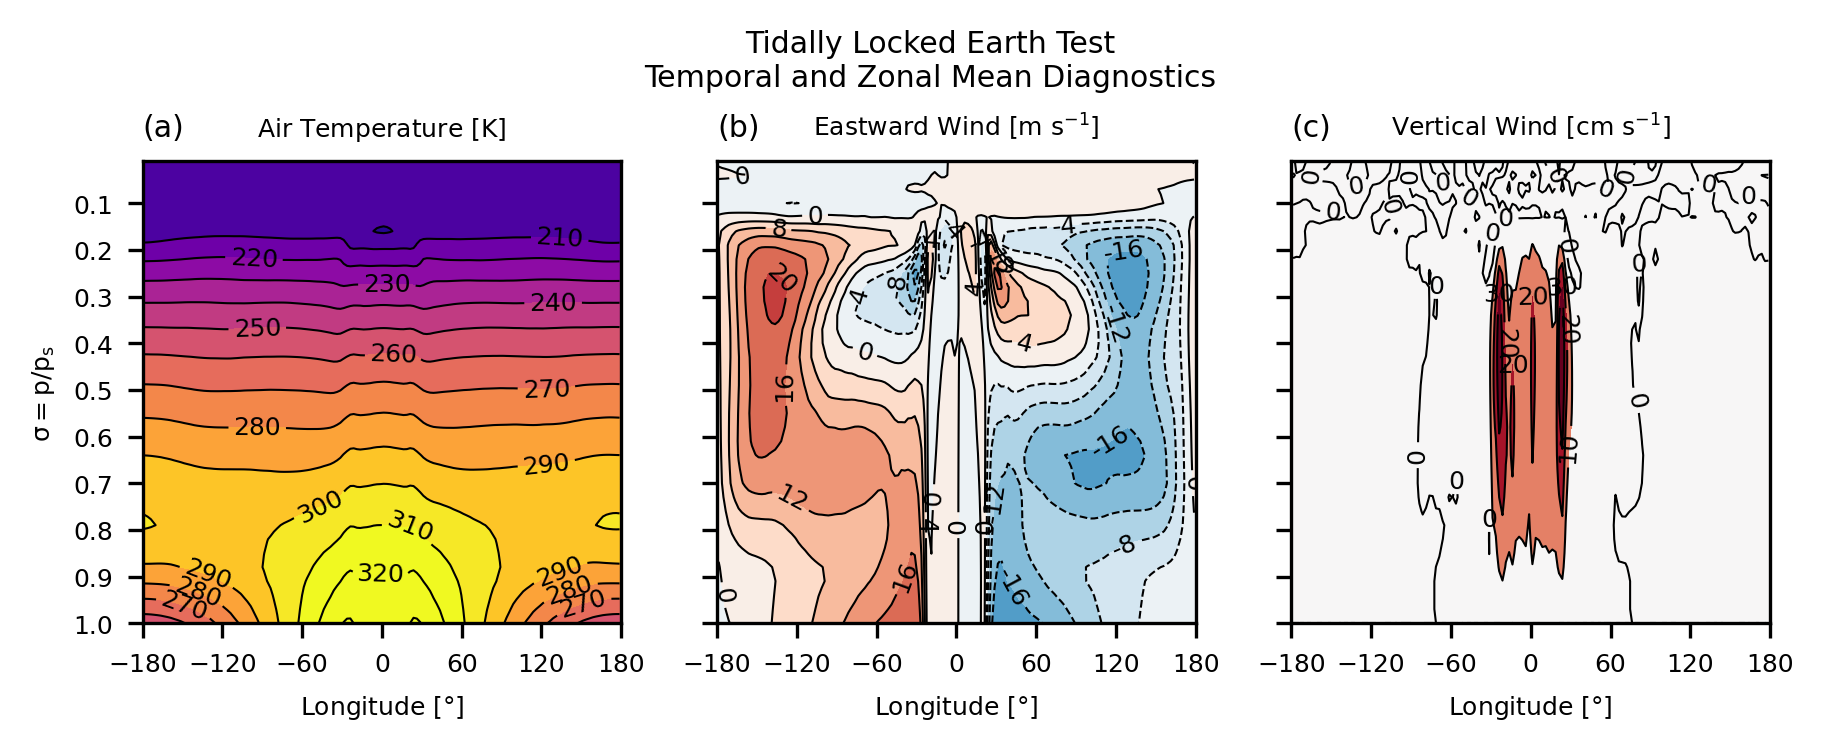

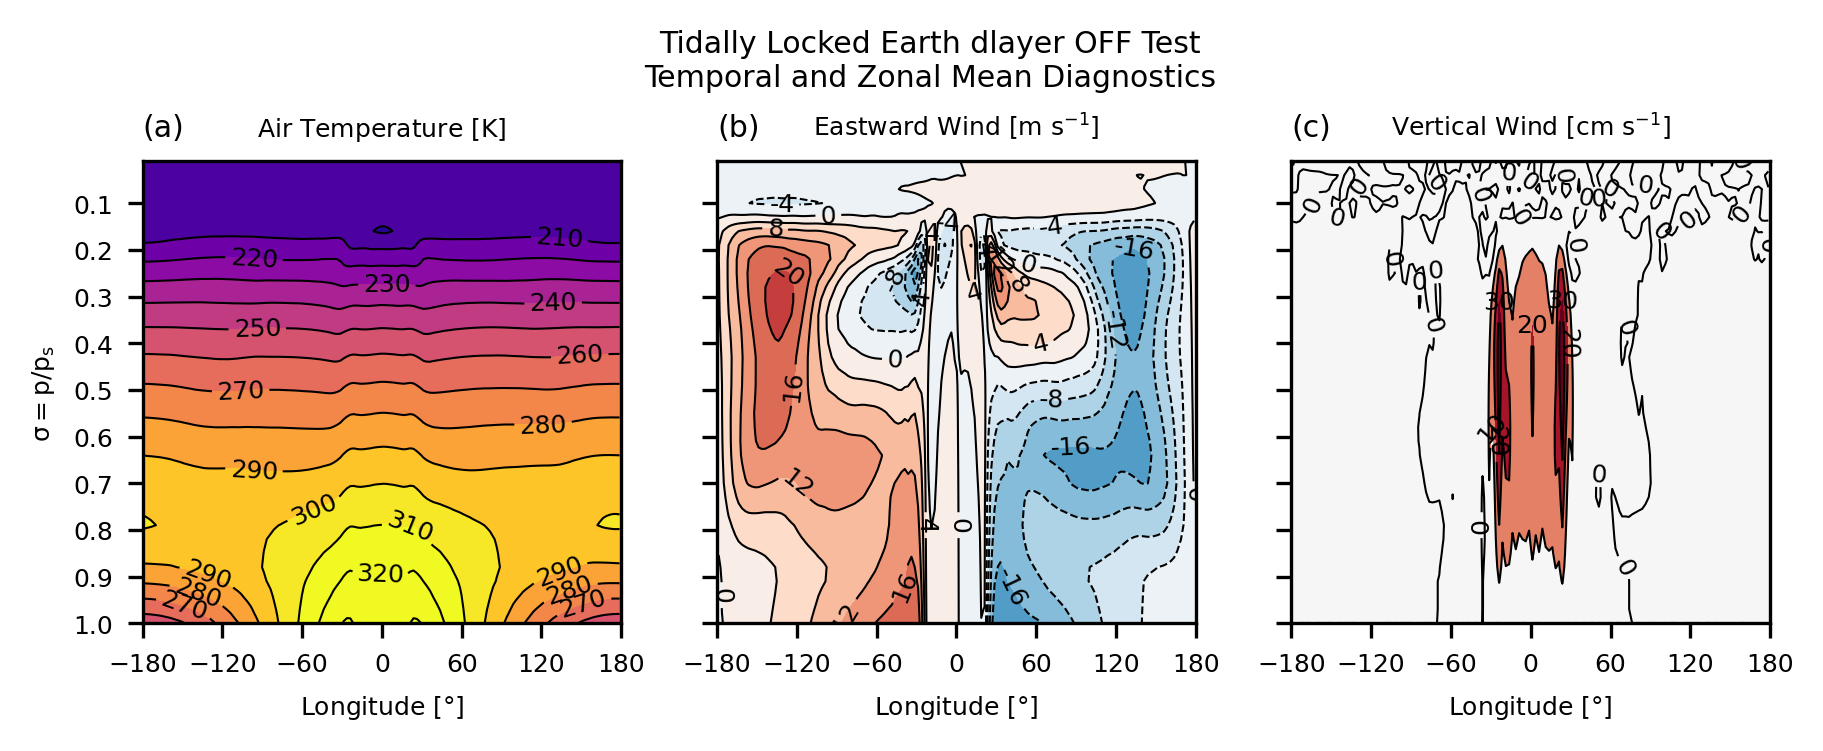

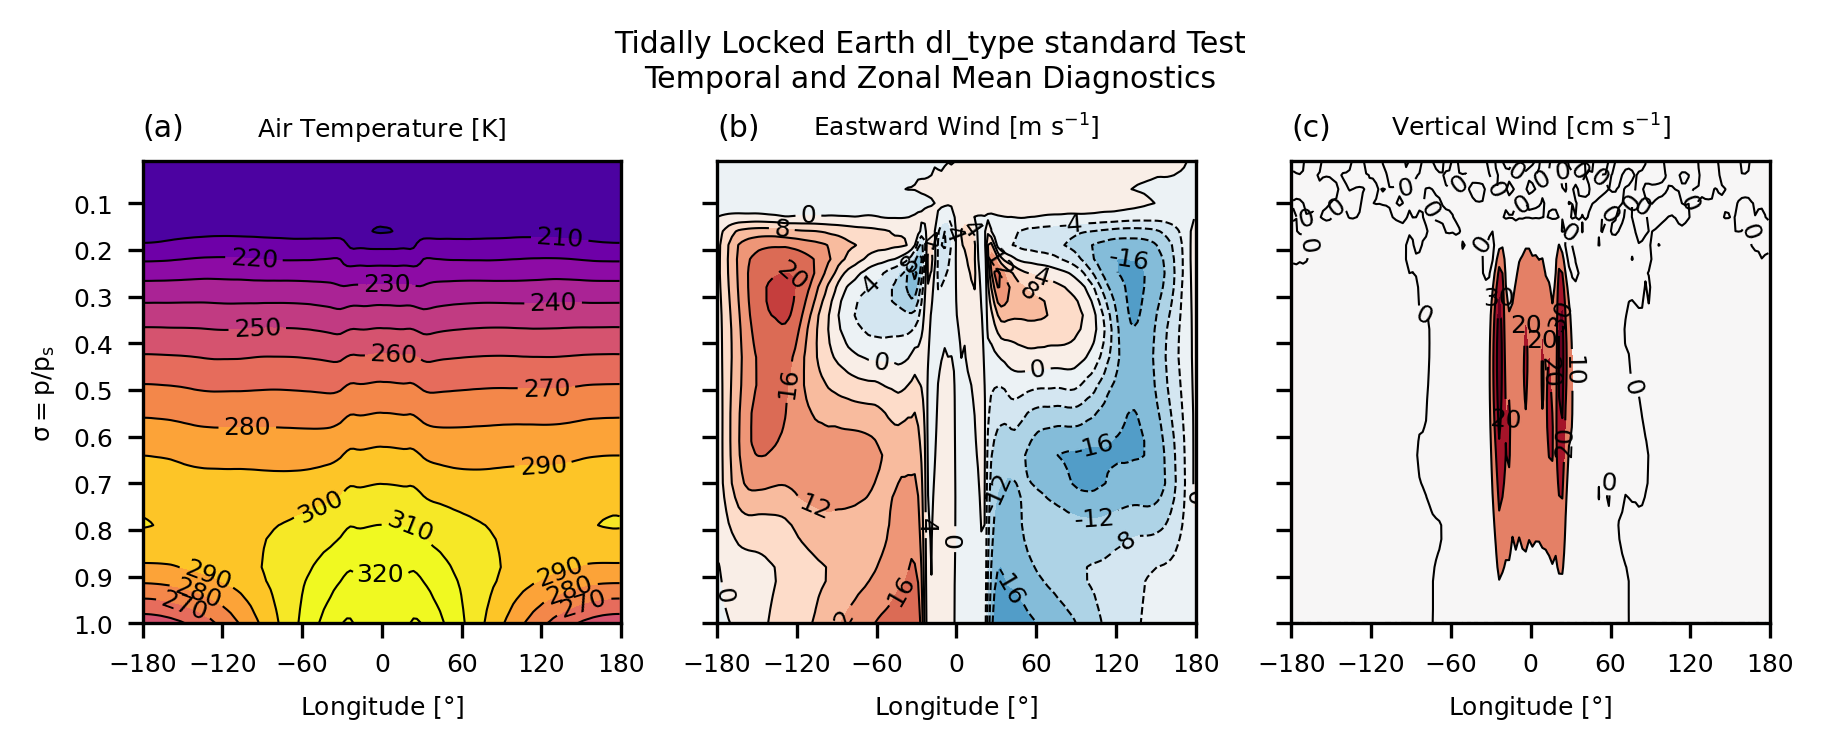

In [25]:
for sim_label in ["tle", "tle_dlayer_off", "tle_dl_type_standard"]:
    sim_prop = SIM_CASES[sim_label]

    fig = plt.figure(figsize=(7, 2))
    fig.suptitle(
        f"{sim_prop['title']} Test\nTemporal and Zonal Mean Diagnostics", y=1.1
    )
    axd = fig.subplot_mosaic(
        qplt.make_list_2d(DIAGS.keys(), ["lfric"]),
        gridspec_kw={"wspace": 0.2},
        sharex=True,
        sharey=True,
    )
    iletters = subplot_label_generator()
    for ax in axd.values():
        ax.set_title(f"({next(iletters)})", loc="left")
        ax.set_xticks(np.arange(-180, 181, 60))
        ax.set_xlim(-180, 180)
        ax.set_yticks(np.arange(1.0, 0.0, -0.1))
        ax.set_ylim(itemgetter(0, -1)(sigma_levels))

        if ax.get_subplotspec().is_last_row():
            ax.set_xlabel("Longitude [$\degree$]")
        if ax.get_subplotspec().is_first_col():
            ax.set_ylabel("$\sigma=p/p_s$")

    for diag_key, diag_prop in DIAGS.items():
        ax = axd[f"{diag_key}-lfric"]
        tex_units = diag_prop["tex_units"]
        ttl = diag_prop["title"]
        if tex_units != "1":
            ttl += f" [{tex_units}]"
        ax.set_title(ttl, size="medium", loc="center")
        # ax.set_title(model_prop["title"], size="medium", loc="right")

        cube = diag_prop["recipe"](runs_sigma_p[sim_label], model=lfric)
        cube.convert_units(tex2cf_units(diag_prop["tex_units"]))
        x = cube.coord(lfric.x).points
        y = cube.coord(lfric.s).points
        z = cube.data

        plt_items = itemgetter("plt_method", "kw_plt", "add_colorbar", "add_clabel")
        for plt_method, kw_plt, add_colorbar, add_clabel in zip(*plt_items(diag_prop)):
            pic = getattr(ax, plt_method)(x, y, z, **kw_plt)
            if add_colorbar:
                fig.colorbar(pic, ax=ax)
            if add_clabel:
                ax.clabel(pic, fmt="%.0f", use_clabeltext=True)
    figsave(
        fig,
        paths.figures
        / "drafts"
        / f"exf__lfric__{sim_label}__eq_sec__{'_'.join(DIAGS.keys())}",
    )

## TL coordinates

In [34]:
from aeolus.calc import (
    cumsum,
    regrid_to_tidally_locked_coordinates,
    rotate_winds_to_tidally_locked_coordinates,
)
from aeolus.calc.diag import lat_cos
from aeolus.meta import const_from_attrs, update_metadata
from iris.util import reverse


@const_from_attrs()
@update_metadata(name="tidally_locked_mass_streamfunction", units="kg s^-1")
def tidally_locked_mass_streamfunction(
    u, v, p_sfc=None, const=None, pole_lon=0, pole_lat=0, model=um
):
    """Mass streamfunction in tidally locked coordinates."""
    const_factor = 2 * np.pi * const.radius
    # Sigma-pressure coordinates
    _, v_tl_cube = rotate_winds_to_tidally_locked_coordinates(
        u, v, pole_lon=pole_lon, pole_lat=pole_lat
    )
    v_tl_cube = regrid_to_tidally_locked_coordinates(
        v_tl_cube, pole_lon=pole_lon, pole_lat=pole_lat
    )
    p_sfc_tl_cube = regrid_to_tidally_locked_coordinates(
        p_sfc, pole_lon=pole_lon, pole_lat=pole_lat
    )
    p_sfc_v_tl_zm = zonal_mean(v_tl_cube * p_sfc_tl_cube)

    sf_tl = reverse(
        cumsum(reverse(p_sfc_v_tl_zm, lfric.s), "s", axis_weights=True, model=lfric),
        lfric.s,
    )
    sf_tl *= const_factor * lat_cos(sf_tl) / const.gravity

    return sf_tl

In [35]:
sim_label = "tle"
sim_prop = SIM_CASES[sim_label]
the_run = runs_sigma_p[sim_label]
const = init_const(sim_prop["planet"], directory=paths.const)

In [36]:
u = runs_sigma_p[sim_label].extract_cube(lfric.u)
v = runs_sigma_p[sim_label].extract_cube(lfric.v)
p_sfc = runs[sim_label].pres.extract(iris.Constraint(**{lfric.z: 0}))
pole_lon = 180

In [37]:
a = tidally_locked_mass_streamfunction(u, v, p_sfc, pole_lon=pole_lon)

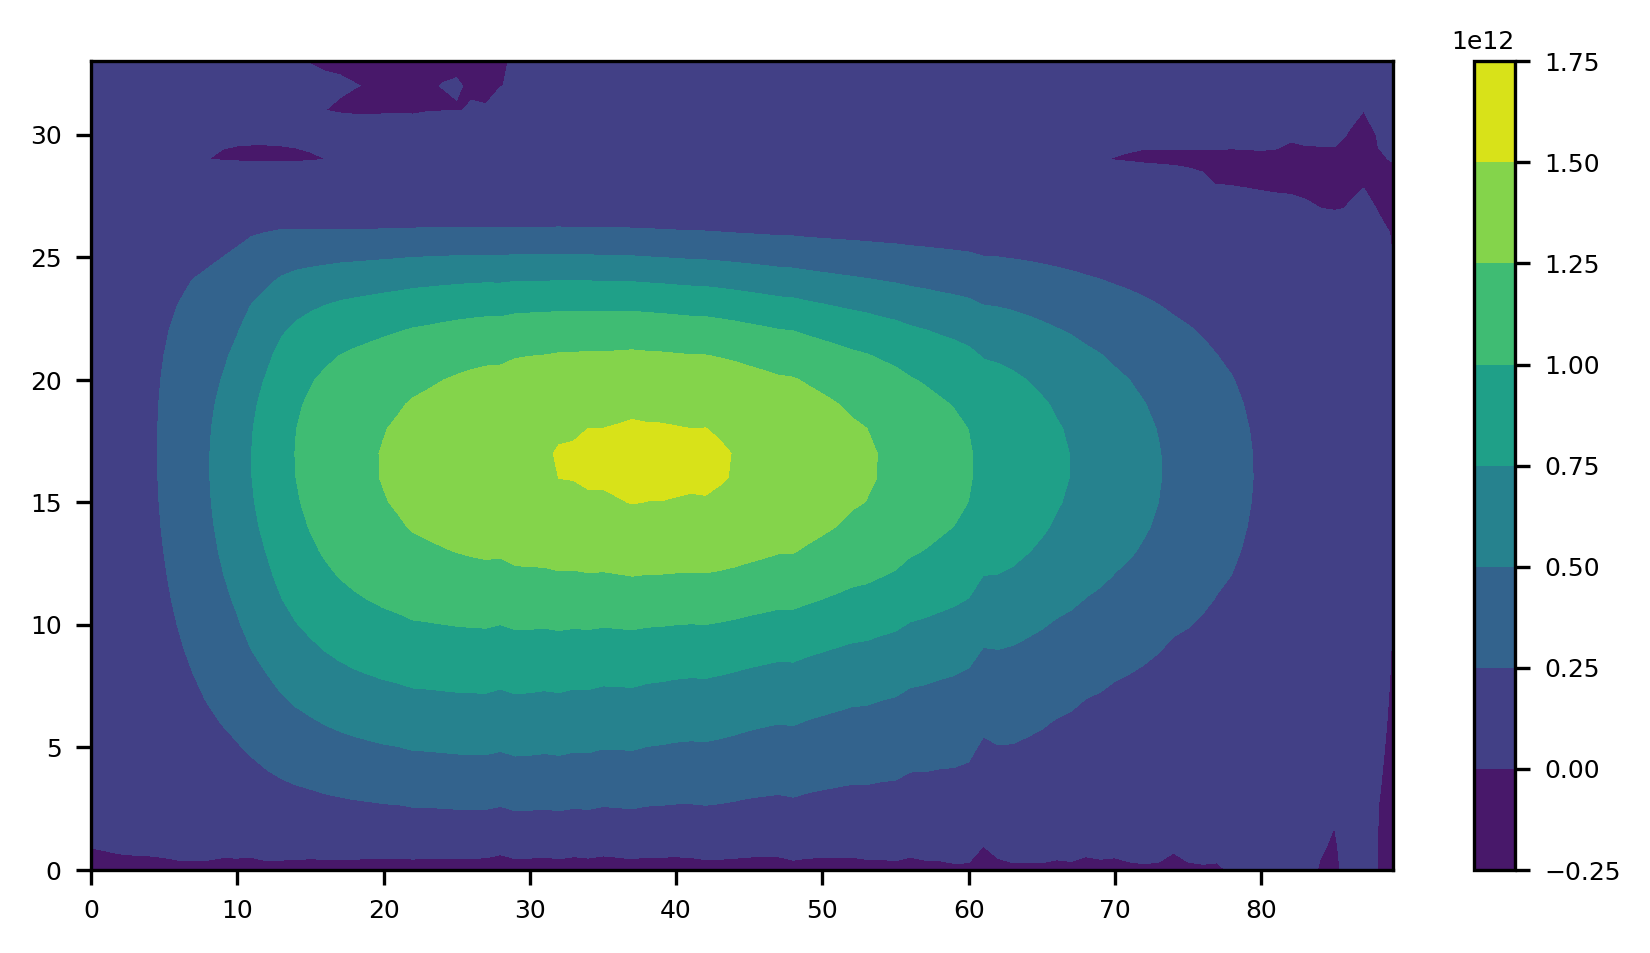

In [38]:
plt.contourf(after_n_day_mean(a, 200).data)
plt.colorbar()

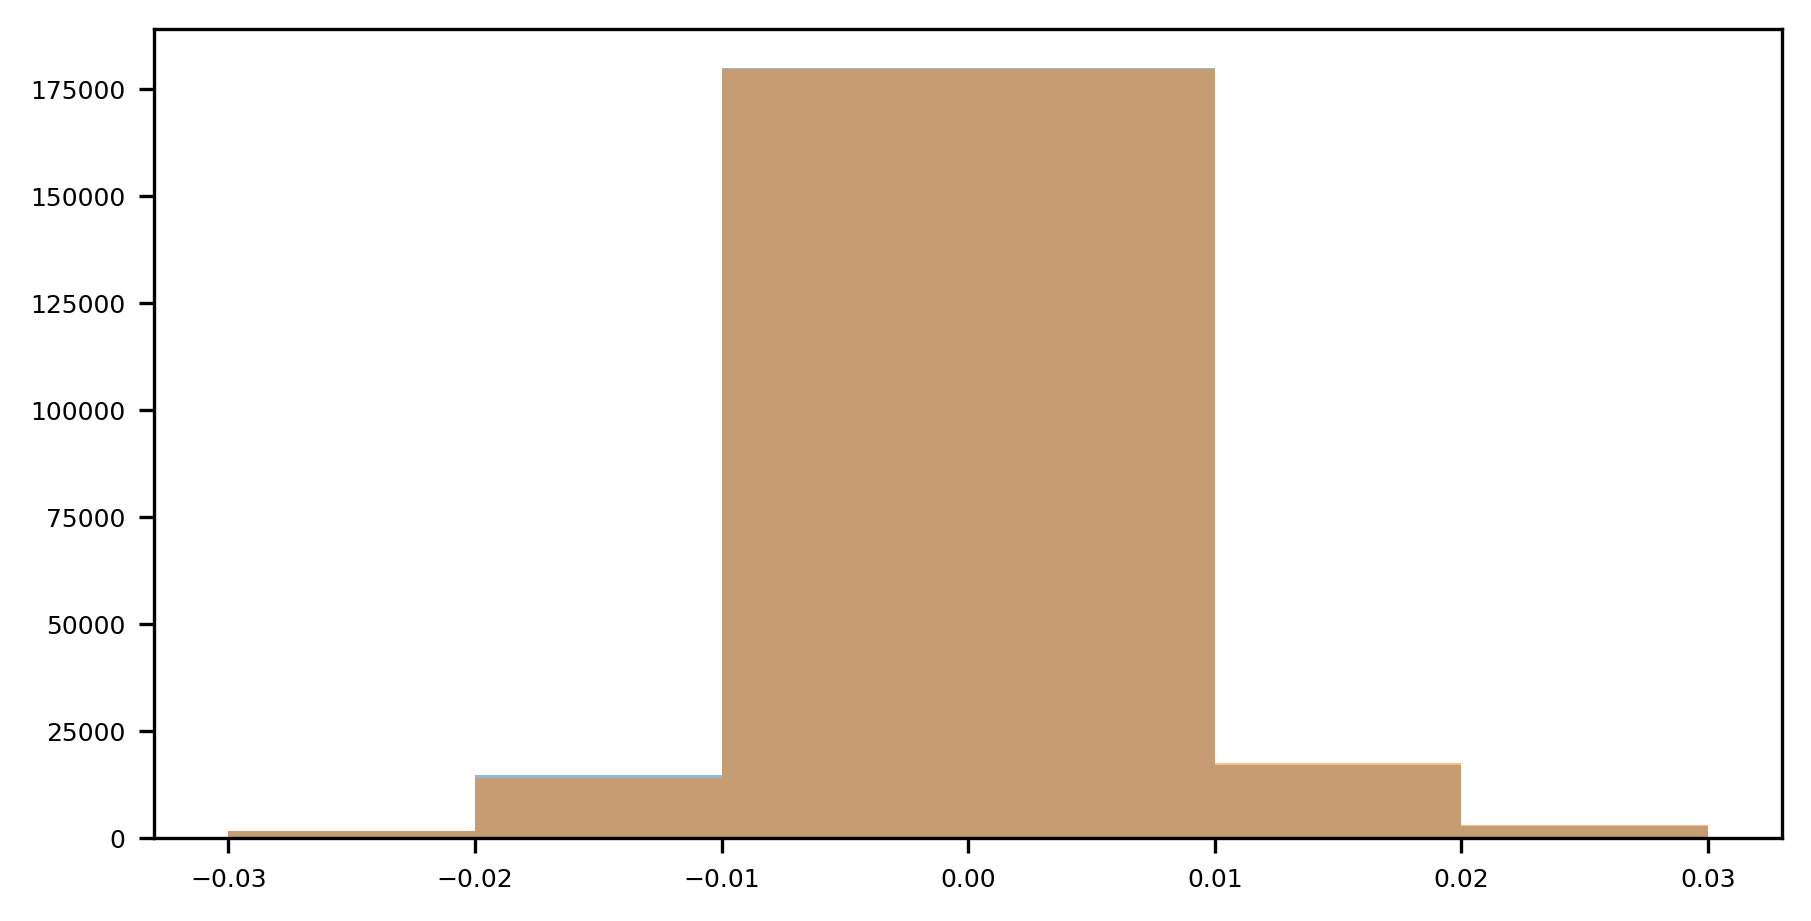

In [104]:
bins = linspace_pm1(3) * 0.03
plt.hist(runs["tle"].w[-100:, -3:, -5:, ...].data.flatten(), bins=bins, alpha=0.5)
plt.hist(
    runs["tle_dlayer_off"].w[-100:, -3:, -5:, ...].data.flatten(), bins=bins, alpha=0.5
);

## Time series

In [17]:
DIAGS = {
    "temp_lev00": {
        "recipe": lambda AS: spatial_mean(isel(AS.temp, um.z, 0)),
        "name": "Air Temperature | Level 0",
        "tex_units": "$K$",
        # "lim": [5, 8],
    },
    "p_sfc": {
        "recipe": lambda AS: spatial_mean(AS.p_sfc),
        "name": "Surface Pressure",
        "tex_units": "$hPa$",
        # "lim": [0, 1.5],
    },
    "w": {
        "recipe": lambda AS: spatial_mean(AS.w),
        "name": "",
        "tex_units": "$m$ $s^{-1}$",
        # "lim": [0, 1.5],
    },
}

Saved to ../figures/exf__um_lfric__hs_el_tle__temp_lev00_p_sfc.png


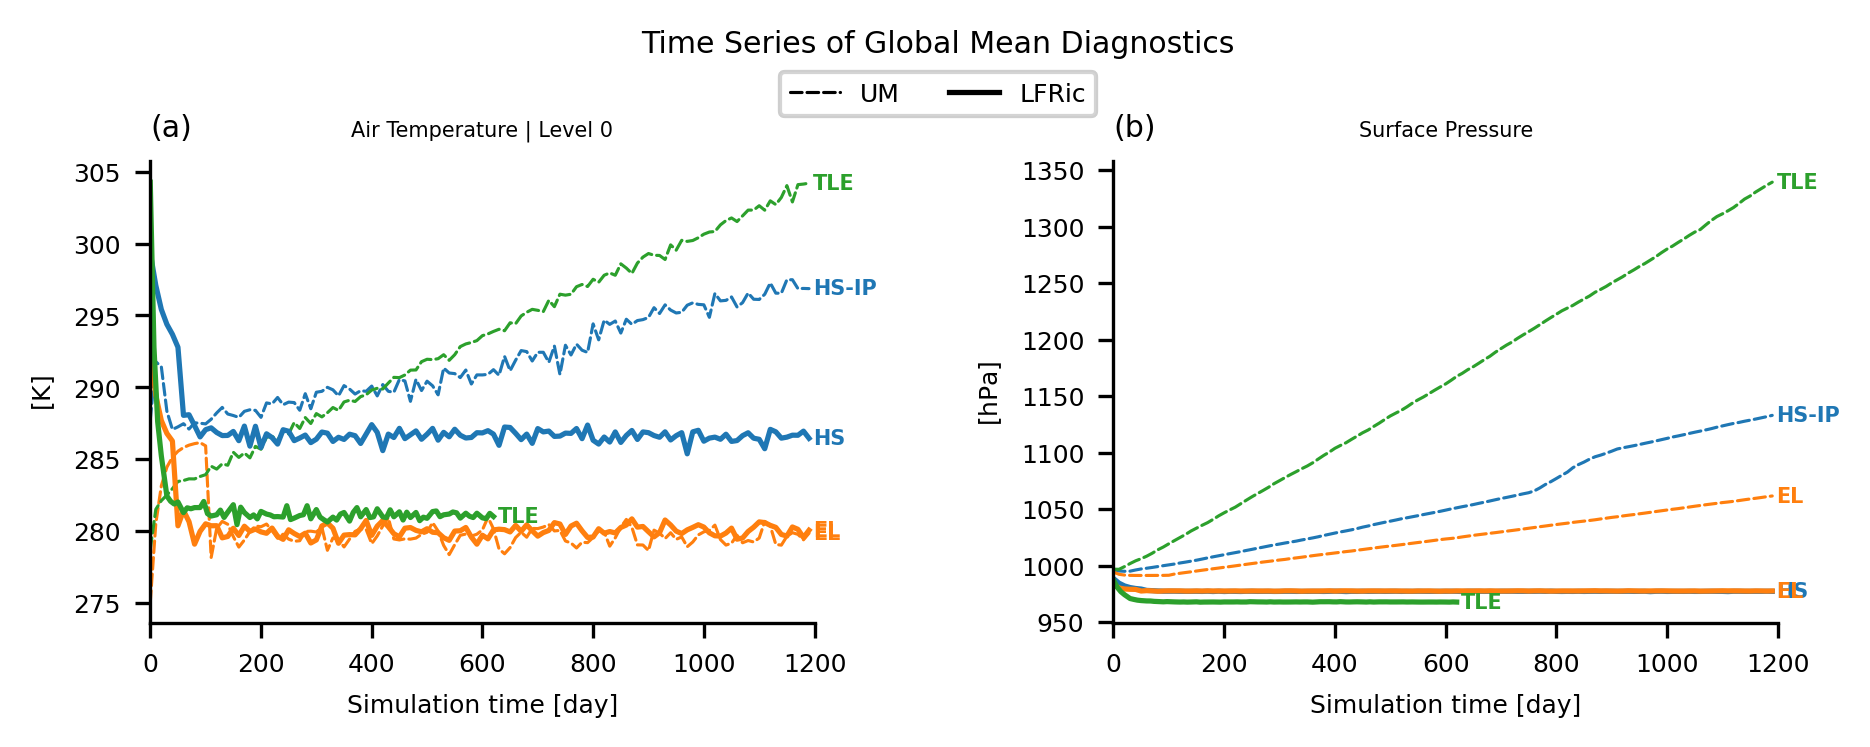

In [23]:
fig = plt.figure(figsize=(7, 2))
fig.suptitle("Time Series of Global Mean Diagnostics", y=1.1)

axd = fig.subplot_mosaic([DIAGS.keys()], gridspec_kw={"wspace": 0.45}, sharex=True)
iletters = subplot_label_generator()
for ax in axd.values():
    ax.set_title(f"({next(iletters)})", loc="left")

for model_key, model_prop in MODELS.items():
    for diag_key, diag_prop in DIAGS.items():
        ax = axd[diag_key]
        ax.set_title(diag_prop["name"], size="small")
        # ax.set_ylim(diag_prop.get("lim"))
        ax.set_ylabel(f"[{diag_prop['tex_units']}]")
        ax.set_xlim(0, 1200)
        ax.set_xticks(np.arange(0, 1201, 200), dtype=int)
        if ax.get_subplotspec().is_last_row():
            ax.set_xlabel("Simulation time [day]")
        ax.spines["right"].set_visible(False)
        ax.spines["top"].set_visible(False)
        for sim_label, sim_prop in SIM_CASES.items():
            cube = diag_prop["recipe"](runs[model_key][sim_label])
            cube.convert_units(tex2cf_units(diag_prop["tex_units"]))
            days = get_cube_rel_days(cube)
            x = days
            y = cube.data
            ax.plot(x, y, **sim_prop["kw_plt"], **model_prop["kw_plt"])
            short_title = sim_prop["short_title"]
            if model_key == "lfric" and sim_label == "hs":
                short_title = short_title.rstrip("-IP")
            ax.annotate(
                text=short_title,
                xy=(x[-1], y[-1]),
                xytext=(1, 0),
                textcoords="offset points",
                va="center",
                color=sim_prop["kw_plt"]["color"],
                fontsize="small",
                weight="bold",
            )
    add_custom_legend(
        fig,
        {v["title"]: {"color": "k", **v["kw_plt"]} for v in MODELS.values()},
        ncol=len(MODELS),
        loc="upper center",
        bbox_to_anchor=(0.5, 1.05),
    )
figsave(
    fig,
    paths.figures
    / f"exf__{'_'.join(MODELS.keys())}__{'_'.join(SIM_CASES.keys())}__{'_'.join(DIAGS.keys())}",
)